### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#%run Visualizer.py # --allows for reloading the particular code

#### Train the network

In [2]:
n = 10
popsize = 10
generations = 100
wrap_around = True
name = 'centered8'
#device = torch.device('mps:0')
device = torch.device('cpu')
#trainer = Evo_Trainer(n, device)
trainer = Evo_Trainer(n, device, popsize)

2023-02-21 20:17:23,662	INFO worker.py:1528 -- Started a local Ray instance.


[2023-02-21 20:17:25] INFO     <38525> evotorch.core: Instance of `Custom_NEProblem` (id:11091611120) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-21 20:17:25] INFO     <38525> evotorch.core: Instance of `Custom_NEProblem` (id:11091611120) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-21 20:17:25] INFO     <38525> evotorch.core: Instance of `Custom_NEProblem` (id:11091611120) -- The `device` of the problem is set as cpu
[2023-02-21 20:17:25] INFO     <38525> evotorch.core: Instance of `Custom_NEProblem` (id:11091611120) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-21 20:17:25] INFO     <38525> evotorch.core: Instance of `Custom_NEProblem` (id:11091611120) -- Number of GPUs that will be allocated per actor is None


In [3]:
trainer.train(generations, name)

              iter : 1
  obj0_median_eval : -398.89910888671875
    obj0_mean_eval : -397.3535461425781
obj0_pop_best_eval : -375.2862243652344
  obj1_median_eval : -0.0
    obj1_mean_eval : 0.0
obj1_pop_best_eval : -0.0
  obj2_median_eval : 0.0
    obj2_mean_eval : 0.3400000035762787
obj2_pop_best_eval : 2.0
  obj3_median_eval : -100.0
    obj3_mean_eval : -100.0
obj3_pop_best_eval : -100.0
  obj4_median_eval : 0.47304365038871765
    obj4_mean_eval : 2.1564486026763916
obj4_pop_best_eval : 23.713788986206055

              iter : 2
  obj0_median_eval : -398.9135437011719
    obj0_mean_eval : -397.44195556640625
obj0_pop_best_eval : -376.3499450683594
  obj1_median_eval : -0.0
    obj1_mean_eval : 0.0
obj1_pop_best_eval : -0.0
  obj2_median_eval : 0.0
    obj2_mean_eval : 0.27000001072883606
obj2_pop_best_eval : 1.0
  obj3_median_eval : -100.0
    obj3_mean_eval : -100.0
obj3_pop_best_eval : -100.0
  obj4_median_eval : 0.5824517011642456
    obj4_mean_eval : 2.288059949874878
obj4_pop

KeyError: 'center'

In [ ]:
network = trainer.get_trained_network()

In [5]:
network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])

KeyError: 'center'

#### Visualize trained network

In [ ]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer(wrap_around)
network(graph, 0)

(Data(x=[30, 10], edge_index=[1, 0], device=cpu, attr=[1]),
 tensor([0., 0.]),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

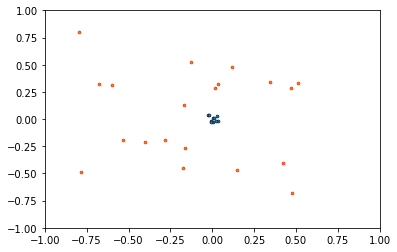

In [ ]:
anim = visualizer.animate_organism(graph, network, food=30, frames=100)
visualizer.save_animation_to_gif(anim, name, 10)

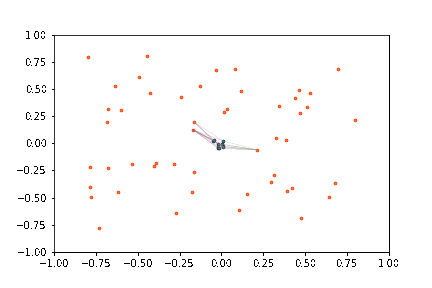

In [ ]:
Image('../animation/' + name + '.gif')

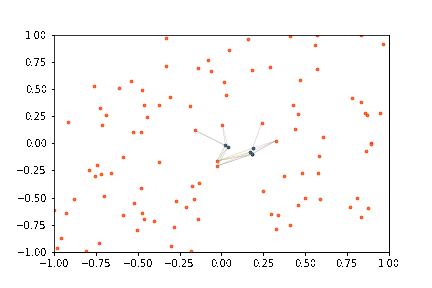

In [ ]:
Image('../animation/GATConv1.gif')

In [ ]:
anim.frame_seq = anim.new_saved_frame_seq() 
IPython.display.HTML(anim.to_jshtml())

In [ ]:
print(network)

CGConv1(
  (conv_layer_cells): CGConv(16, dim=4)
  (conv_layer_food): CGConv(16, dim=4)
  (mlp_before): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
  )
  (mlp_middle): Sequential(
    (0): ReLU()
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Linear(in_features=4, out_features=2, bias=True)
    (6): Tanh()
  )
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(16, 16, K=1, normalization=sym)
    (conv_h_z): ChebConv(16, 16, K=1, normalization=sym)
    (conv_x_r): ChebConv(16, 16, K=1, normalization=sym)
    (conv_h_r): ChebConv(16, 16, K=1, normalization=sym)
    (conv_x_h): ChebConv(16, 16, K=1, normalization=sym)
    (conv_h_h): ChebConv(16, 16, K

In [ ]:
print('conv_layers1: ', network.conv_layer_cells)
for param in network.conv_layer_cells.parameters():
  print(param.data)

print('conv_layers2: ', network.conv_layer_food)
for param in network.conv_layer_food.parameters():
  print(param.data)

conv_layers1:  CGConv(16, dim=4)
tensor([[ 4.3767e-01,  3.0045e-01, -1.2071e-01,  1.6886e-01, -1.0057e-01,
         -5.8045e-01,  1.4527e-01,  2.8317e-01, -4.2803e-01,  6.1933e-01,
         -2.4582e-02, -4.3404e-01,  2.6315e-01,  4.0849e-01, -1.8811e-01,
         -1.7287e-01,  3.6736e-02, -6.0752e-01,  8.5449e-02,  3.6636e-01,
          1.1153e-02,  3.3369e-01,  3.9893e-01, -2.6978e-01, -2.8941e-01,
         -1.8357e-01, -3.7172e-02,  9.1617e-02, -4.4278e-01,  4.3710e-01,
         -6.3895e-02,  2.0360e-01,  1.5792e-01,  1.1670e-01, -3.6766e-01,
         -2.0411e-01],
        [-1.9569e-01,  9.0293e-02, -4.9153e-01,  3.5848e-01,  4.1579e-01,
          1.3842e-01, -2.7254e-01, -5.0373e-01,  3.9720e-01,  2.3187e-01,
         -4.8831e-01,  2.3372e-02,  1.9733e-02, -1.7713e-01, -2.1224e-01,
         -5.2663e-01, -3.0251e-01,  3.7360e-01,  5.8279e-01,  2.8004e-01,
         -4.5322e-01,  2.4614e-01, -2.4774e-01,  2.1664e-01, -4.9603e-01,
          3.2058e-01,  5.5741e-02,  2.2395e-02,  1.4699e

In [ ]:
print('GConvGRU: ', network.gConvGRU)
for param in network.gConvGRU.parameters():
  print(param.data)


GConvGRU:  GConvGRU(
  (conv_x_z): ChebConv(16, 16, K=1, normalization=sym)
  (conv_h_z): ChebConv(16, 16, K=1, normalization=sym)
  (conv_x_r): ChebConv(16, 16, K=1, normalization=sym)
  (conv_h_r): ChebConv(16, 16, K=1, normalization=sym)
  (conv_x_h): ChebConv(16, 16, K=1, normalization=sym)
  (conv_h_h): ChebConv(16, 16, K=1, normalization=sym)
)
tensor([-0.3980, -0.0594,  0.4497, -0.0640, -0.1523, -0.4289,  0.2401,  0.2470,
        -0.5300,  0.1492,  0.0023,  0.1290, -0.5456,  0.1577,  0.3420, -0.3336])
tensor([[ 3.4529e-01, -4.0367e-01,  6.3532e-01,  3.3643e-01, -4.5607e-01,
          2.9095e-01, -1.3803e-01, -3.5072e-02, -1.1567e-01,  4.8323e-01,
         -3.3339e-01, -9.2186e-02,  2.4042e-02,  2.6699e-01, -5.3879e-01,
          1.0243e-01],
        [ 6.4374e-02, -4.9570e-01, -5.3879e-01, -3.0455e-01,  1.8146e-01,
         -5.1850e-01,  2.0152e-01,  3.1057e-01, -8.0642e-01,  2.6156e-01,
          1.8298e-01, -3.8077e-01,  3.6720e-02,  1.0612e-01, -4.1674e-01,
         -2.1870e-0

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

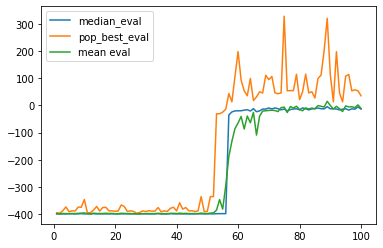

In [ ]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#plt.plot(losses.stepsize)
plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()